<a href="https://colab.research.google.com/github/LEEINSEO-0118/HD_AI_Challenge/blob/main/ML_Project_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning 프로젝트 수행을 위한 코드 구조화

- ML project를 위해서 사용하는 템플릿 코드를 만듭니다.

1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

## 1. 라이브러리, 데이터 불러오기

In [55]:
# 설치에 필요한 라이브러리들이 있다면 모두 적어둡니다. anaconda에 기본적으로 설치되지 않은 라이브러리들을 적어두세요.
!pip install lightgbm optuna

In [56]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

In [57]:
# flag setting
feature_reducing = False

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# 데이터를 불러옵니다.
file_path = '/content/drive/MyDrive/ai부트캠프/Machine_Learning/DATA/HD_challenge/'
train = pd.read_csv(file_path + 'train.csv')
test = pd.read_csv(file_path + 'test.csv')
print(train.shape, test.shape)

(367441, 27) (244989, 26)


## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

In [60]:
display(train.iloc[:,:14].head(3))
train.iloc[:,14:].head(3)

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH
0,TRAIN_000000,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,20.0,10.0,38600,220.0
1,TRAIN_000001,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,20.0,10.0,28100,220.0
2,TRAIN_000002,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,20.0,10.0,96400,300.0


,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CHMT36,"China, People's Republic Of",0.14,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,CUFV52,Singapore,-3.16,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,ISIG88,Liberia,0.00,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500


In [61]:
# Info()를 통한 전체적인 데이터 파악
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367441 entries, 0 to 367440
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SAMPLE_ID           367441 non-null  object 
 1   ARI_CO              367441 non-null  object 
 2   ARI_PO              367441 non-null  object 
 3   SHIP_TYPE_CATEGORY  367441 non-null  object 
 4   DIST                367441 non-null  float64
 5   ATA                 367441 non-null  object 
 6   ID                  367441 non-null  object 
 7   BREADTH             367440 non-null  float64
 8   BUILT               367441 non-null  int64  
 9   DEADWEIGHT          367441 non-null  int64  
 10  DEPTH               367440 non-null  float64
 11  DRAUGHT             367440 non-null  float64
 12  GT                  367441 non-null  int64  
 13  LENGTH              367440 non-null  float64
 14  SHIPMANAGER         367441 non-null  object 
 15  FLAG                367441 non-nul

count    367441.000000
mean         61.877118
std         170.575224
min           0.000000
25%           0.000000
50%           7.949444
75%          49.153333
max        2159.130556
Name: CI_HOUR, dtype: float64


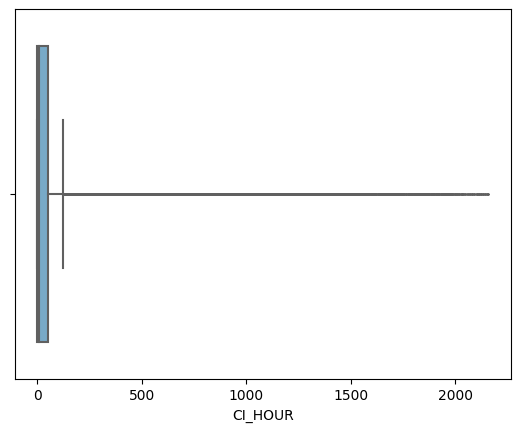


        target outlier cnt : 45786
        target outlier percenate : 12.46%
      


In [62]:
# Target 분석
print(train.CI_HOUR.describe())
# 이상치에 데이터가 굉장히 많은 것으로 판단됨.
sns.boxplot(data = train, x = 'CI_HOUR', fliersize=0.5, palette = 'Blues')
plt.show()
# CI_HOUR(대기시간) 이상치 개수
IQR = train.CI_HOUR.quantile(0.75)-train.CI_HOUR.quantile(0.25)
target_outlier_cnt = train.CI_HOUR[train.CI_HOUR > train.CI_HOUR.quantile(0.75) + (1.5 * IQR)].count()
print(f'''
        target outlier cnt : {target_outlier_cnt}
        target outlier percenate : {round(target_outlier_cnt/train.CI_HOUR.count() * 100, 2)}%
      ''')


# Outlier가 많은 이유는 무엇일까?

count    154366.000000
mean         56.751802
std         162.452287
min           0.000000
25%           0.000000
50%           5.424861
75%          43.451806
max        2159.130556
Name: CI_HOUR, dtype: float64


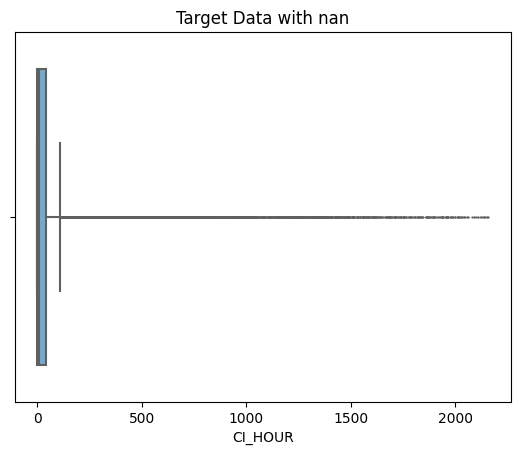


        target outlier cnt : 19776
        target outlier percenate : 12.81%
      

        target means (not null) : 65.59024395944778
        target means (with null) : 56.751802255280204
        


In [63]:
# U_WIND, V_WIND, AIR_TEMPERATURE, BN의 결측치가 많다.
train_null = train[train.isnull().any(axis = 1)]
train_not_null = train[~train.isna().any(axis = 1)]

# 결측치 데이터를 가지는 target의 통계량
print(train_null.CI_HOUR.describe())
# print(train_not_null.CI_HOUR.describe())

# 결측치 데이터를 가지는 traget의 boxplot
plt.title('Target Data with nan')
sns.boxplot(data = train_null, x = 'CI_HOUR', fliersize=0.5, palette = 'Blues')
plt.show()
# 결측치 데이터를 가지는 target의 outlier 비율
IQR = train_null.CI_HOUR.quantile(0.75)-train_null.CI_HOUR.quantile(0.25)
target_outlier_cnt = train_null.CI_HOUR[train_null.CI_HOUR > train_null.CI_HOUR.quantile(0.75) + (1.5 * IQR)].count()
print(f'''
        target outlier cnt : {target_outlier_cnt}
        target outlier percenate : {round(target_outlier_cnt/train_null.CI_HOUR.count() * 100, 2)}%
      ''')
print(f'''
        target means (not null) : {train_not_null.CI_HOUR.mean()}
        target means (with null) : {train_null.CI_HOUR.mean()}
        ''')

# 결측치 데이터들의 traget 분포와 오리지널데이터의 traget은 이상치가 12% 정도로 분포의 형태는 비슷하지만
# target 평균값의 경우, 결측치를 가지는 경우에는 65, 결측치가 없는 경우에는 56 정도의 차이를 보여준다. 표준편차가 160~170인 상황에서 평균 65, 56이 큰 의미가 있는지는 모르겠다.

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리

### 결측치 처리 - knn imputation
### datetime 처리
### Categorical feature encoding - LabelEncoder를 통한 ordinal encoding

#### SAMPLE_ID 제거

In [64]:
train = train.drop(columns = ['SAMPLE_ID'])

#### datetime 처리

In [72]:
# datetime 컬럼 처리
train.ATA = pd.to_datetime(train['ATA'])

# datetime 변환
for df in [train]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)

#### Categorical feature 처리

In [73]:
from tqdm import tqdm
import bisect
from sklearn.preprocessing import LabelEncoder

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]


#### 결측치 처리

In [65]:
from sklearn.impute import KNNImputer

In [66]:
train[train.isna().any(axis = 1)].iloc[:, 14:]

,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
5,"Hong Kong, China",NaN,NaN,NaN,NaN,22,45.75,48.89,45.92,820.288044,0.001743,42.078056
8,"Hong Kong, China",NaN,NaN,NaN,NaN,15,54.49,55.52,53.17,796.790931,0.000552,0.000000
9,"Hong Kong, China",NaN,NaN,NaN,NaN,18,64.25,66.86,63.39,1030.009758,0.000103,73.985833
10,"China, People's Republic Of",NaN,NaN,NaN,NaN,11,70.66,70.76,65.01,1610.724314,0.001660,31.891944
11,Panama,NaN,NaN,NaN,NaN,9,29.22,30.32,27.94,287.791271,0.000026,4.185556
...,...,...,...,...,...,...,...,...,...,...,...,...
367427,Panama,NaN,NaN,NaN,NaN,13,32.19,37.28,37.04,471.884296,0.001028,186.698889
367428,"China, People's Republic Of",NaN,NaN,NaN,NaN,22,60.99,62.45,57.47,1574.233684,0.000360,141.522500
367432,Tuvalu,NaN,NaN,NaN,NaN,3,59.81,61.56,52.89,1203.463363,0.000256,70.663611
367435,Cyprus,NaN,NaN,NaN,NaN,10,80.08,82.34,77.40,1404.453239,0.000058,0.000000


In [68]:
# df = pd.DataFrame({
#     'First' : [100, 80, np.nan, 60],
#     'Second' : [20, 55, 76, np.nan],
#     'Thrid' : [np.nan, 70, 60, 88]
# })

# display(df)

# imputer = KNNImputer(n_neighbors = 2, weights = 'distance')
# data_filled = imputer.fit_transform(df)
# data = pd.DataFrame(data_filled)
# data.columns = df.columns
# data.to_csv(file_path + 'data.csv')
# data

In [ ]:
imputer = KNNImputer(n_neighbors = 1, weights = 'distance')
data_filled = imputer.fit_transform(train)
data = pd.DataFrame(data_filled)
data.columns = train.columns
data.to_csv(file_path + 'data.csv')
data

#### 상관계수 처리

In [ ]:
# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.
correlated_features =

<ipython-input-33-d30f59f87530>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data = train.corr(), annot = True, fmt = '.2f', cmap = 'Blues')


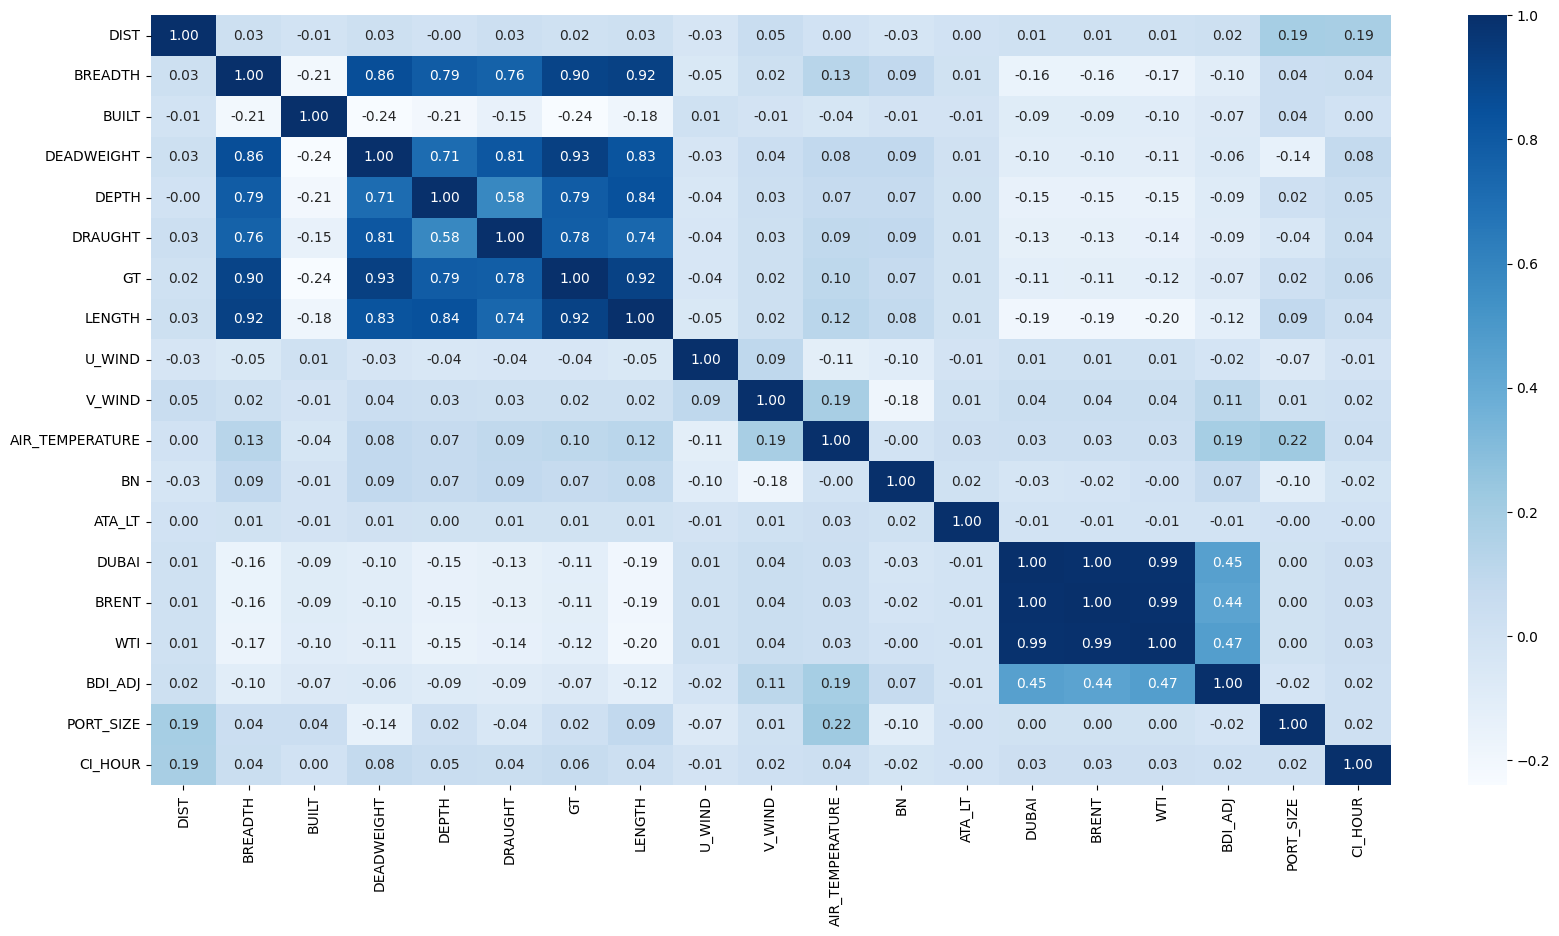

In [33]:
plt.figure(figsize = (20, 10))
sns.heatmap(data = train.corr(), annot = True, fmt = '.2f', cmap = 'Blues')
plt.show()

### 4. 학습 데이터 분할

In [ ]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
from sklearn.model_selection import train_test_split

X = train.drop(['CI_HOUR'])
y = train.CI_HOUR

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.05, random_state = 42)

In [ ]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

### 5. 학습 및 평가

In [ ]:
# 간단하게 LightGBM 테스트
# 적당한 hyper-parameter 조합을 두었습니다. (항상 best는 아닙니다. 예시입니다.)

param_grid = {
    "max_bin" : 20,
    "learning_rate" : 0.0025,
    "objective" : "regression",
    "boosting_type" : "gbdt",
    "metric" : "mae",
    "sub_feature" : 0.345,
    "bagging_fraction" : 0.85,
    "bagging_freq" : 40,
    "num_leaves" : 512,
    "min_data" : 500,
    "min_hessian" : 0.05,
    "verbose" : 2,
    "feature_fraction_seed" : 2,
    "bagging_seed" : 3
}

model = LGBMRegressor(**param_grid)

In [ ]:
print("\nFitting LightGBM...")
model.fit(X_train, y_train)

In [ ]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
evaluation_metric =

In [ ]:
print("Prediction")
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)


train_score = evaluation_metric(y_train, pred_train)
val_score = evaluation_metric(y_val, pred_val)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % val_score)

### 6. Hyper-parameter Tuning

> GridSearchCV

** LightGBM의 hyperparameter **

[Official Documentation] https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

[Blog 1] https://smecsm.tistory.com/133

[Blog 2] https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

[Blog 3] https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

> optuna를 사용해봅시다 !

In [ ]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators =
    max_depth =
    max_features =


    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 max_features=max_features)


    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    losses = []

    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)


    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [ ]:
K = # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

study = optuna.create_study(direction="") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=5)

In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

In [ ]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

### 7. 테스트 및 제출 파일 생성

In [ ]:
## X_test 만들기
X_test =


In [ ]:
best_params =

best_model = RandomForestRegressor(**best_params)

best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
preds

In [ ]:
X_test # 원본 데이터랑 id가 맞는지 확인 해보기!

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')
submission

In [ ]:
submission.to_csv("submission.csv", index=False)